In [1]:
import torch
import torch.nn as nn
from torch import topk
from torchvision import transforms
from PIL import Image

import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class2num = {'broad leaves': 0, 'coniferous tree': 1, 'grass land': 2, 'hard ground': 3, 'leafless': 4, 'stalk': 5, 'stone': 6, 'trunk': 7, 'water': 8, 'wire': 9}
num2class = {0: 'broad leaves', 1: 'coniferous tree', 2: 'grass land', 3: 'hard ground', 4: 'leafless', 5: 'stalk', 6: 'stone', 7: 'trunk', 8: 'water', 9: 'wire'}

resize = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
device = torch.device('cpu')

data_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

# alexnet = torch.load('alexnet-111_10_5_5.pkl', map_location=torch.device('cpu'))
# vgg19 = torch.load('vgg19-111_8_5_5.pkl', map_location=torch.device('cpu'))
# res50 = torch.load('resnet50-111_3_5_5.pkl', map_location=torch.device('cpu'))
res152 = torch.load('resnet152-111_5_5_5.pkl', map_location=torch.device('cpu'))

models = {
#     'AlexNet'    :alexnet,
#     'VGG19'     :vgg19,
#     'ResNet50'  :res50,
    'ResNet152' :res152
}

In [3]:
features = np.zeros(shape=(1,3))
# np.concatenate((features, np.array([1,2,3]), ))
ff = np.concatenate((features, [[1,2,3]]), axis=0)
ff = np.delete(ff, [0], axis=0)
ff

array([[1., 2., 3.]])

In [26]:
import cv2
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        # define the resnet152
        self.resnet = models['ResNet152']
        
        # isolate the feature blocks
        self.features = nn.Sequential(self.resnet.conv1,
                                      self.resnet.bn1,
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                      self.resnet.layer1, 
                                      self.resnet.layer2, 
                                      self.resnet.layer3, 
                                      self.resnet.layer4)
        
        # average pooling layer
        self.avgpool = self.resnet.avgpool
        
        # classifier
        self.classifier = self.resnet.fc
    
    def forward(self, x):
        
        # extract the features
        x = self.features(x)

        x = self.avgpool(x)
        x = x.view((1, -1))
     
        return x
    
def get_features_from_single_image(model, image):
    model.eval()
    im = Image.open(image).convert("RGB")
    tsr = data_transforms(im).unsqueeze(0)
    with torch.no_grad():
        output = model.forward(tsr)
    features_for_single_image = output.detach().numpy()
    return features_for_single_image

def get_features_from_folder(model, folder,id2class):
    imgs = [os.path.join(folder, img) for img in os.listdir(folder) if os.path.isfile(os.path.join(folder, img))]
    labels = []
    features_for_folder = np.zeros((1, 2048))
    for img in imgs:
#         img_id = int(os.path.basename(img).split['.'][0][1])
        img_id = int(os.path.basename(img).split('.')[0][1])
        img_label = id2class[img_id]
        labels.append(img_label)
        features = get_features_from_single_image(model, img)
#         features_for_folder.append(features)
        features_for_folder = np.concatenate((features_for_folder, features))
    features_for_folder = np.delete(features_for_folder, [0], axis=0)
    return imgs, labels, features_for_folder

def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

def scale_image(image, max_image_size):
    image_height, image_width, _ = image.shape

    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    image = cv2.resize(image, (image_width, image_height))
    return image

def draw_rectangle_by_class(image, label):
    image_height, image_width, _ = image.shape

    # get the color corresponding to image class
    color = colors_per_class[label]
    image = cv2.rectangle(image, (0, 0), (image_width - 1, image_height - 1), color=color, thickness=5)

    return image

def fix_random_seeds():
    seed = 10
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

# m = 255.
# colors_per_class = {
#     'broad leaves' : list(e/m for e in [254, 202, 87]),
#     'coniferous tree' : list(e/m for e in [255, 107, 107]),
#     'hard ground' : list(e/m for e in [10, 189, 227]),
#     'leafless' : list(e/m for e in [255, 159, 243]),
#     'stalk' : list(e/m for e in [16, 172, 132]),
#     'stone' : list(e/m for e in [128, 80, 128]),
#     'trunk' : list(e/m for e in [87, 101, 116]),
#     'grass land' : list(e/m for e in [52, 31, 151]),
#     'water' : list(e/m for e in [0, 0, 0]),
#     'wire' : list(e/m for e in [100, 100, 255]),
# }

colors_per_class = {
    'broad leaves' : 'lime',
    'coniferous tree' : 'forestgreen',
    'hard ground' : 'k',
    'leafless' : 'grey',
    'stalk' : 'cyan',
    'stone' : 'darkorange',
    'trunk' : 'purple',
    'grass land' : 'deeppink',
    'water' : 'deepskyblue',
    'wire' : 'red',
}


markers_per_class = {
    'broad leaves' : 'D',
    'coniferous tree' : '>',
    'hard ground' : 'p',
    'leafless' : '1',
    'stalk' : 'd',
    'stone' : 's',
    'trunk' : '*',
    'grass land' : 'x',
    'water' : 'o',
    'wire' : '_',
}


id2class = {
    0:'broad leaves',
    1:'coniferous tree',
    2:'hard ground',
    3:'leafless',
    4:'stalk',
    5:'stone',
    6:'trunk',
    7:'grass land',
    8:'water',
    9:'wire',
    }

# ResNet()
img = './samples/000019.jpg'
int(os.path.basename(img).split('.')[0][1])

0

In [27]:
# max(1, 2, 3)

In [28]:
# model = ResNet()
# model.eval()
# # image_path = './samples/000019.jpg'

# # imgs = os.listdir('./samples/')
# # imgs = [os.path.join('./samples', img) for img in imgs]
# folder = './samples/'
# # folder = './few_samples/'
# max_value = 255.
# data = get_features_from_folder(model, folder, id2class)

In [29]:
imgs = np.load('./features_of_test_images/featues_imgs.npy')
labels = np.load('./features_of_test_images/featues_labels.npy')
features = np.load('./features_of_test_images/featues_features.npy')
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(features)
tsne = scale_to_01_range(tsne)

In [30]:
tx = tsne[:, 0]
ty = tsne[:, 1]
for x, y in zip(tx, ty):
    print(x, y)
    break

0.4452338 0.85734165


In [31]:
colors_per_class

{'broad leaves': 'lime',
 'coniferous tree': 'forestgreen',
 'hard ground': 'k',
 'leafless': 'grey',
 'stalk': 'cyan',
 'stone': 'darkorange',
 'trunk': 'purple',
 'grass land': 'deeppink',
 'water': 'deepskyblue',
 'wire': 'red'}

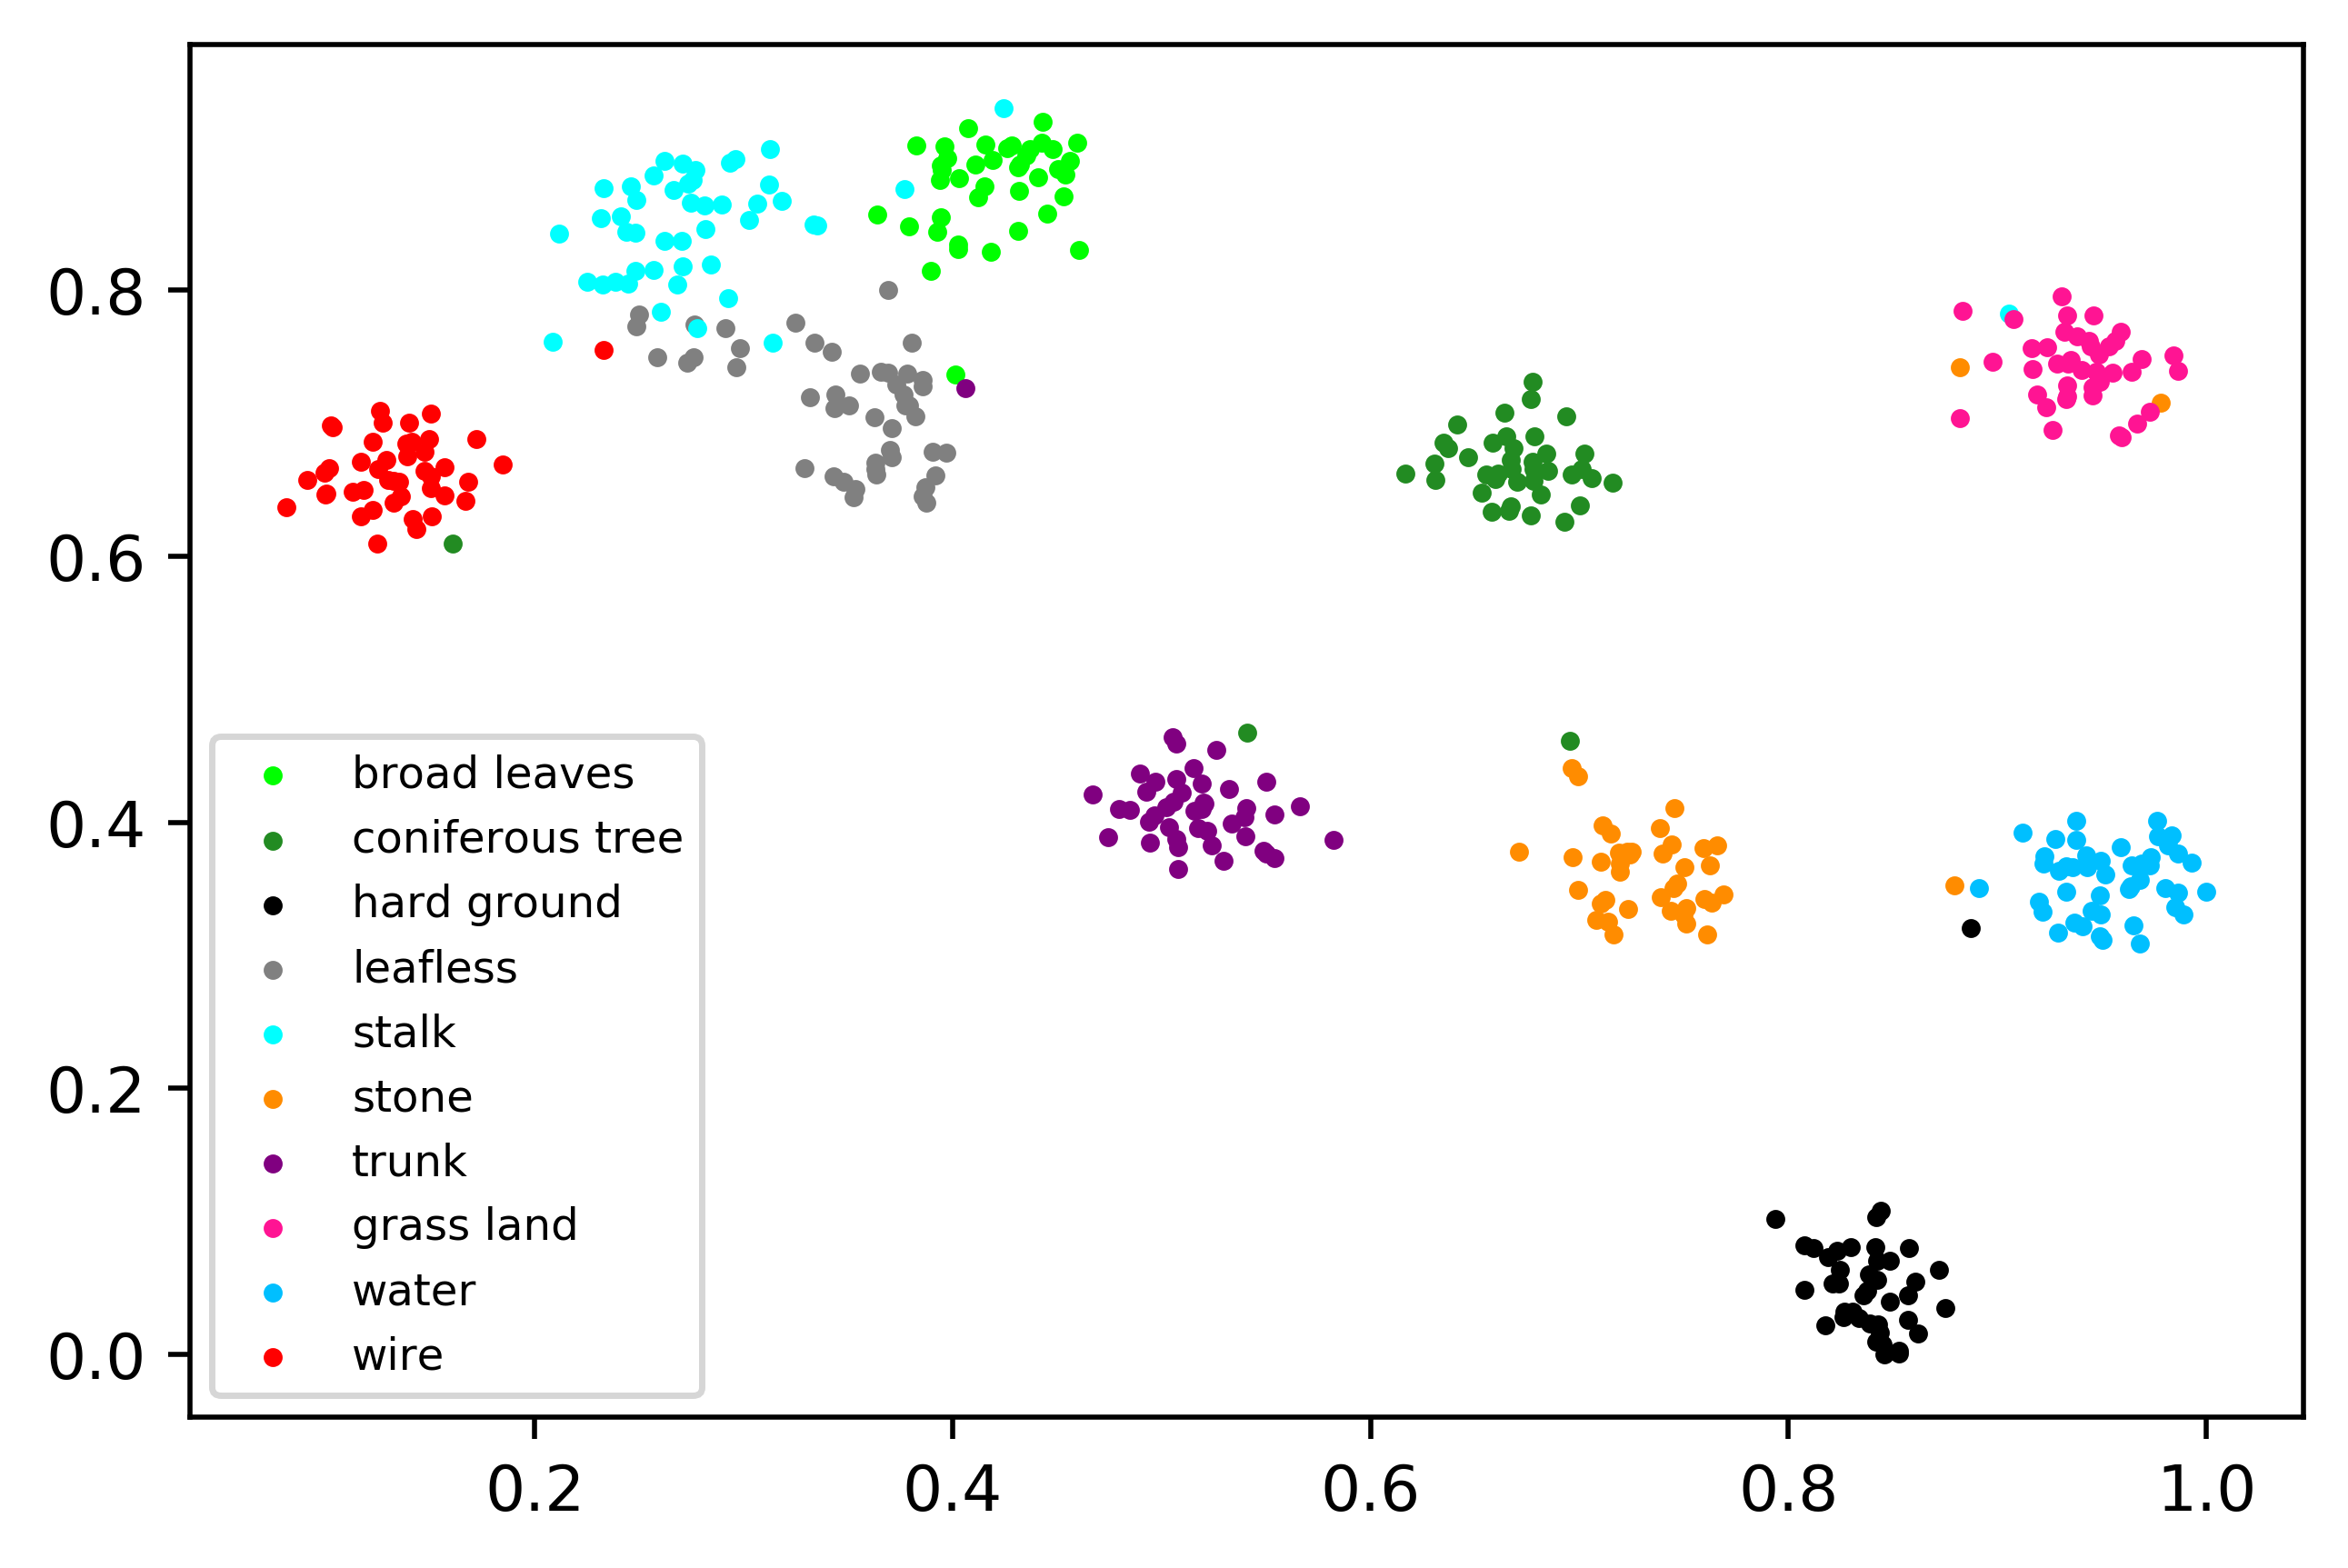

In [34]:
fig = plt.figure(
#     figsize=(6, 4), 
    dpi=500)
ax = fig.add_subplot(111)
ft = {
    'family':'Times New Roman',
    'weight':'bold',
    'size':12,
    }
# for every class, we'll add a scatter plot separately
for label in colors_per_class.keys():
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]

    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)

    # convert the class color to matplotlib format
#     color = np.array(colors_per_class[label], dtype=np.float) / 255
    color = colors_per_class[label]

    # add a scatter plot with the corresponding color and label
    ax.scatter(
        current_tx, 
        current_ty, 
        c=color, 
        label=label,
        s=4
    
#         marker=markers_per_class[label]
    )

# build a legend using the labels we set previously
ax.legend(
    loc='best', 
#     bbox_to_anchor=(0.5, 0.5),
    fontsize = 'x-small',
)
plt.savefig('tsne_of_classes.png', dpi=500)
# finally, show the plot
plt.show()

In [11]:
model = ResNet()
model.eval()
# image_path = './samples/000019.jpg'

imgs = os.listdir('./few_samples/')
imgs = [os.path.join('./few_samples', img) for img in imgs]
folder = './few_samples/'
max_value = 255.

colors_per_class
# features = []
# for image_path in imgs:
#     features_for_single_image = get_features(model=model, image=image_path)
#     features.append(features_for_single_image)
# features = np.array(features)
# features, features.shape

data = get_features_from_folder(model, folder, id2class)

In [12]:
scale_to_01_range(features).shape

(435, 2048)

In [13]:
# features.resize((10, 2048))
# features.shape

In [14]:
features

array([[0.        , 0.35120291, 2.8485055 , ..., 0.89274693, 0.14298689,
        0.37548375],
       [0.53617251, 0.06504371, 1.71687317, ..., 0.59834665, 0.44161412,
        0.17374597],
       [0.28294468, 0.25669807, 1.18045008, ..., 0.96699929, 0.11335674,
        0.43467331],
       ...,
       [0.59791929, 0.4289619 , 0.18299679, ..., 0.11578648, 0.16598855,
        0.13042523],
       [1.46521997, 0.45195881, 0.10872631, ..., 0.25985938, 0.05690746,
        0.114921  ],
       [2.26195979, 0.7950477 , 0.        , ..., 0.15367585, 0.0139145 ,
        0.13562447]])

In [15]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

ValueError: could not convert string to float: 'lime'

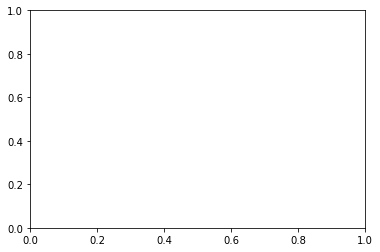

In [16]:
# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)

# for every class, we'll add a scatter plot separately
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]

    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)

    # convert the class color to matplotlib format
    color = np.array(colors_per_class[label], dtype=np.float) / 255

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=label)

# build a legend using the labels we set previously
ax.legend(loc='best')

# finally, show the plot
plt.show()

In [ ]:
f, ax = plt.subplots()
ax.set_xticks(range(16))
ax.set_yticks(range(16))
# ax.text(5, 5, 'dog', fontdict={'size':12, 'color':(254./255, 202./255, 87./255)})
# plt.show()
for x, cat in zip(range(1, 11), list(colors_per_class.keys())):
    ax.text(x, x, cat, fontdict={'family':'Times New Roman', 'size':18, 'weight':'bold', 'color':colors_per_class[cat]})

In [ ]:
max[254, 202, 87]